In [1]:
import pandas as pd 
import numpy as np
import requests
import urllib
import matplotlib.pyplot as plt 

# Research Question 

How inclusive / representitive is Citi Bike of New York City Demographics in 2017? 

    - How inclusive are Citbike stations in NYC? 
    - How well does citbike station locations correspond with usage? 

# Data Collection and Cleaning 

### Stations Data

I downloaded the raw station data from an online source which contained all of the citbike data. The first thing I did was to delete the row with latitidue = 45.506264191001186, since this station is not located in NYC. Perhaps it was a data entry error from Citibike. But this is not a concern as it is only one row out of a total of almost 1000 rows. 

In [84]:
#This is a table containing all of the stations owned by citibike in NYC. 
stations = pd.read_csv('stations.csv')
stations = stations[stations['lat'] != 45.506264191001186] 
#remove this station since it is located in canada not NYC.
#45.506264191001186, -73.56890559196472

In [85]:
#This gets the (lat,lon) of all of the citibike stations in NYC 
stations_lat = list(stations['lat'])
stations_lon = list(stations['lon'])
stations_lat_lon = [(stations_lat[i],stations_lon[i]) for i in range(len(stations_lat))]

To obtain the geoid which is the unique identifier of the census tract that the station is located in, I used the following online API. 

In [88]:
#This uses a freely available goverment API that allows us to get the geoid based on the (lat,lon) of each citibike sttaion.
station_geoid = []
for lat, lon in stations_lat_lon: 
    #Encode parameters 
    params = urllib.parse.urlencode({'latitude': lat, 'longitude':lon, 'format':'json'})
    #Contruct request URL
    url = 'https://geo.fcc.gov/api/census/block/find?' + params

    #Get response from API
    response = requests.get(url)

    #Parse json in response
    data = response.json()

    #Print FIPS code
    returned_FIPS = (data['Block']['FIPS'])
    geoid = returned_FIPS[:11] 
    station_geoid.append(geoid)

In [89]:
stations_geoid = [int(geoid) for geoid in station_geoid]

In [91]:
#add the geoid column to the stations table
stations['geoid'] = stations_geoid

Here I rename some columns to make their names more intuitive and also remove all stations made after 2017, as we are going to base our analysis on the year 2017, so any Citibike stations made after it is irrelevant

In [10]:
stations = stations.drop('Unnamed: 0',axis=1)
stations.rename(columns={'id':'station_id', 'name':'station_name','first':'first_trip','last':'last_trip'},inplace=True)
stations['first_trip'] = pd.to_datetime(stations['first_trip'])
stations['last_trip'] = pd.to_datetime(stations['last_trip'])
#only select stations made during or before 2017 
stations = stations[stations['first_trip'] <= datetime.datetime(2017,12,30)]

In [13]:
stations_geoid.to_csv('citibike_stations_geoid_final.csv',index=False)

### Race and Income Data 

I downloaded the raw race and income data from the internet and performed the following operations to clean it up. 

In [2]:
race_and_income = pd.read_csv('race_and_income_data.csv')

Since our project will be focusing on the year 2017, we only require the race and income data from that year

In [3]:
#only interested in 2017 data 
race_and_income = race_and_income[['geoid','2017 median income','2017 median income margin of error', 
     '2017 race: total households', '2017 race: total households margin of error', '2017 race: White',
    '2017 race: Black', '2017 race: Asian', '2017 race: Other', '2017 race: 2 or more races']]

Removing rows where the median income is not an integer. Also some median income values are '250,000+' and I changed these to '250,000' so that they can be treated as integers. 

In [4]:
#removing rows with non-integer median income values
race_and_income = race_and_income[race_and_income['2017 median income'] != '-']
race_and_income['2017 median income'] = race_and_income['2017 median income'].apply(lambda x: 250000 if x=='250,000+' else x)
race_and_income = race_and_income[race_and_income['2017 median income margin of error'] != '***']
race_and_income = race_and_income.astype({'2017 median income': 'int64', '2017 median income margin of error':'int64'})

In [5]:
race_and_income.to_csv('race_and_income_final.csv',index=False)

# Data Description 

# Data Limitations 

# Explaratory Data Analysis 

### Exploring Citi Bike Trip Data

In [73]:
# read the csv file
df = pd.read_csv('./final_trip_data.csv')

In [19]:
df.dtypes

Unnamed: 0               int64
Unnamed: 0.1           float64
tripduration             int64
starttime               object
stoptime                object
start station name      object
end station name        object
usertype                object
birth year             float64
gender                   int64
start_station_geoid    float64
end_station_geoid      float64
dtype: object

In [20]:
#transform to datetime object
df['starttime']=pd.to_datetime(df['starttime'], format='%Y-%m-%d %H:%M:%S')

In [22]:
df['stoptime']=pd.to_datetime(df['stoptime'], format='%Y-%m-%d %H:%M:%S')

In [23]:
df.dtypes

Unnamed: 0                      int64
Unnamed: 0.1                  float64
tripduration                    int64
starttime              datetime64[ns]
stoptime               datetime64[ns]
start station name             object
end station name               object
usertype                       object
birth year                    float64
gender                          int64
start_station_geoid           float64
end_station_geoid             float64
dtype: object

In [ ]:
#drop columns where user's are subs

##### Trips by time 

In [24]:
df['start hour']=df['starttime'].dt.hour.astype('category')
df['start day']=df['starttime'].dt.day.astype('category') 
df['weekday']=df['starttime'].dt.weekday.astype('category')

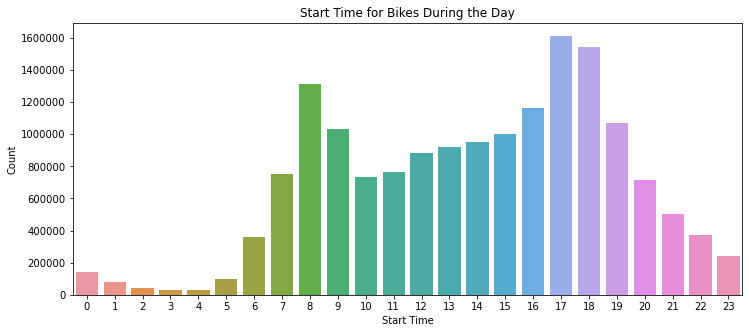

In [71]:
plt.figure(figsize=(12,5))
time= sns.countplot(data=df, x="start hour")
plt.ticklabel_format(style='plain', axis='y')
time.set(xlabel='Start Time', ylabel='Count',title="Start Time for Bikes During the Day")
plt.show()

From this graph we can see that people tend to ride bikes mostly at 8-9am, and 4-7pm usual times when people commute from and to work. This graph was made excluding the weekends. 

##### Number of Trips Per Month

In [31]:
df['months']=df['starttime'].dt.month.astype('category')

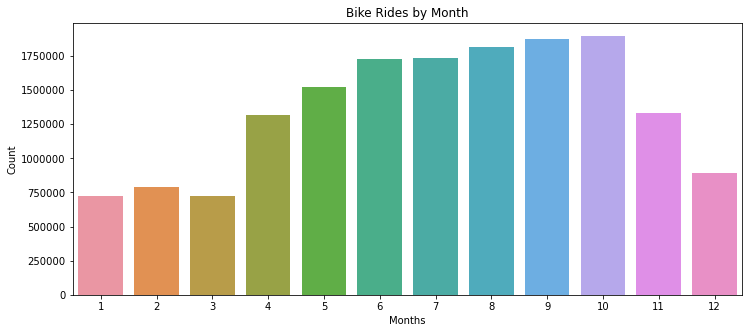

In [42]:

plt.figure(figsize=(12,5))
time= sns.countplot(data=df, x="months");
plt.ticklabel_format(style='plain', axis='y')
time.set(xlabel='Months', ylabel='Count',title="Bike Rides by Month")
plt.show()

From this we can see that in 2017, people ride bikes the most at times from April to October when the weather is warm

##### Trip Duration Plot

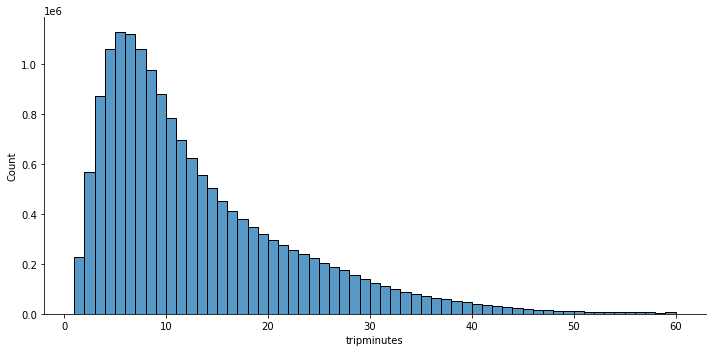

In [8]:
df['tripminutes'] = df['tripduration'] // 60
sns.displot(data=df,x="tripminutes", bins=range(1,61), aspect=10/5);

For trip duration by minutes we get a right-skewed graph where most of the trip times don't exceed 20minutes. 
From this we can see that New York City bike-riders don't travel very far distances.

### Exploring Race and Income data and Stations data

In [5]:
stations_geoid = pd.read_csv('data_cleaning/citbike_stations/citibike_stations_geoid_final.csv')

In [6]:
race_and_income = pd.read_csv('data_cleaning/race_and_income/race_and_income_final.csv')

Here I join the race_and_income table with the stations table on the geoid column. (Geoid is the unique identifier of a given census tract (region in NYC))

In [7]:
combined_table = (stations_geoid.set_index('geoid')).join((race_and_income.set_index('geoid')),how='inner')

In [8]:
combined_table['geoid'] = combined_table.index
combined_table.reset_index(drop=True,inplace=True)

In [9]:
combined_table.columns

Index(['station_id', 'station_name', 'lat', 'lon', 'first_trip', 'last_trip',
       'rides', '2017 median income', '2017 median income margin of error',
       '2017 race: total households',
       '2017 race: total households margin of error', '2017 race: White',
       '2017 race: Black', '2017 race: Asian', '2017 race: Other',
       '2017 race: 2 or more races', 'geoid'],
      dtype='object')

##### Summary Satistics of the race_and_income table and the stations table

In [7]:
stations_geoid.describe()

,station_id,lat,lon,rides,geoid
count,839.000000,839.000000,839.000000,839.000000,8.390000e+02
mean,2194.866508,40.732725,-73.972622,96824.084625,3.605797e+10
std,1445.801651,0.039650,0.023913,110102.215903,9.827592e+06
min,72.000000,40.646538,-74.025353,124.000000,3.604700e+10
25%,431.500000,40.697945,-73.991102,17642.500000,3.604703e+10
50%,3124.000000,40.732233,-73.975739,50612.000000,3.606101e+10
75%,3401.500000,40.763154,-73.953847,147736.500000,3.606101e+10
max,3654.000000,40.814394,-73.907744,801965.000000,3.608102e+10


In [8]:
race_and_income.describe()

,geoid,2017 median income,2017 median income margin of error,2017 race: total households,2017 race: total households margin of error,2017 race: White,2017 race: Black,2017 race: Asian,2017 race: Other,2017 race: 2 or more races
count,4.787000e+03,4787.000000,4787.000000,4787.000000,4787.000000,4787.000000,4787.000000,4787.000000,4787.000000,4787.000000
mean,3.606167e+10,68452.919783,12274.519323,4110.058283,361.894715,2623.683309,642.620639,343.286818,378.091289,122.376227
std,3.150101e+07,33577.801513,8163.393942,1919.727188,205.322620,1804.265041,1040.428579,607.656810,700.859938,148.342969
min,3.600100e+10,9053.000000,1034.000000,19.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.604702e+10,45774.000000,7009.500000,2711.500000,230.500000,1154.000000,44.000000,28.000000,29.000000,34.000000
50%,3.606101e+10,61951.000000,10399.000000,3844.000000,321.000000,2415.000000,178.000000,119.000000,114.000000,82.000000
75%,3.608110e+10,84862.500000,15224.000000,5154.000000,457.000000,3786.500000,792.500000,377.500000,374.000000,160.500000
max,3.612315e+10,248438.000000,119997.000000,28937.000000,2225.000000,14516.000000,17020.000000,7822.000000,7375.000000,3000.000000


##### Comaparing average income and race  between census tracts with the 10 most citibike stations vs census tracts with 1 station

In [9]:
geoid_top_10_most_stations = combined_table.groupby('geoid')['station_id']
geoid_top_10_most_stations = geoid_top_10_most_stations.count().sort_values(ascending=False)[0:10].index #list of geoids containing the top 10 most stations

In [10]:
geoid_one_station = combined_table.groupby('geoid')['station_id'].count() == 1
geoid_one_station = geoid_one_station[geoid_one_station==True].index #list of geoids containing 1 station

In [11]:
#data frame for race and income with only entries for geoids that have the top 10 most stations 
top_10_stations_geoid_race_income_df = race_and_income[race_and_income['geoid'].isin(geoid_top_10_most_stations)]
#data frame for race and income with only entries for geoids that have one station
one_station_geoid_race_income_df = race_and_income[race_and_income['geoid'].isin(geoid_one_station)]

In [12]:
mean_income_in_top_10_locations = top_10_stations_geoid_race_income_df['2017 median income'].mean()
mean_income_in_locations_w_one_station = one_station_geoid_race_income_df['2017 median income'].mean()

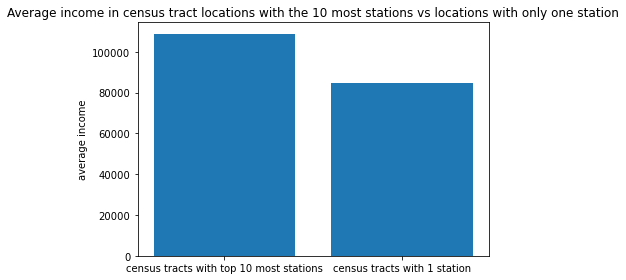

In [13]:
plt.bar(['census tracts with top 10 most stations','census tracts with 1 station'],[mean_income_in_top_10_locations,mean_income_in_locations_w_one_station])
plt.ylabel('average income')
plt.title('Average income in census tract locations with the 10 most stations vs locations with only one station')
plt.tight_layout()
plt.show()

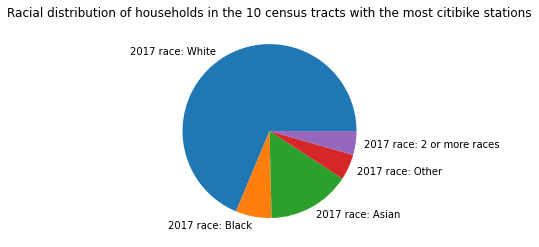

In [14]:
top_10_race_sum = top_10_stations_geoid_race_income_df[['2017 race: White','2017 race: Black','2017 race: Asian','2017 race: Other','2017 race: 2 or more races']].sum()
mylabels = top_10_race_sum.index
plt.pie(top_10_race_sum,labels=mylabels)
plt.title('Racial distribution of households in the 10 census tracts with the most citibike stations')
plt.show()

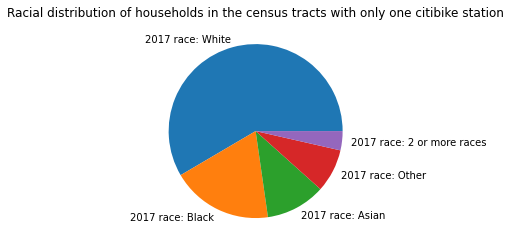

In [15]:
one_station_geoid_race_sum = one_station_geoid_race_income_df[['2017 race: White','2017 race: Black','2017 race: Asian','2017 race: Other','2017 race: 2 or more races']].sum()
mylabels = one_station_geoid_race_sum.index
plt.pie(one_station_geoid_race_sum,labels=mylabels)
plt.title('Racial distribution of households in the census tracts with only one citibike station')
plt.show()

From these results we see that the 10 locations with the most Citibike stations has a higher average income compared to the locations with only one citibike station. We also see that the locations that have a higher number of stations also have a much smaller proportion of Black households as seen by the much smaller Orange segment in the first piechart. Thus, we will explore this relationship between the number of stations in a given area and the race and income distribution of the area further in our project. 

##### Corelation between number of stations in a census tract, income, and race

In [16]:
#produce a data frame with columns geoid, and the number of stations in that geoid
geoid_station_count_df = combined_table.groupby('geoid')[['station_id']].count()
geoid_station_count_df.rename(columns={'station_id':'num_stations_in_census_tract'},inplace=True)
geoid_station_count_df.reset_index(inplace=True)

In [17]:
race_and_income_station_count_df= race_and_income.set_index('geoid').join(geoid_station_count_df.set_index('geoid'),how='inner')
print('Correlation between the number of stations in the census tract with the race and income data in that census tract \n')
race_and_income_station_count_df[['2017 median income','2017 race: total households','2017 race: White',
       '2017 race: Black', '2017 race: Asian', '2017 race: Other',
       '2017 race: 2 or more races', 'num_stations_in_census_tract']].corr()[['num_stations_in_census_tract']]

Correlation between the number of stations in the census tract with the race and income data in that census tract 



,num_stations_in_census_tract
2017 median income,0.170209
2017 race: total households,0.068914
2017 race: White,0.110627
2017 race: Black,-0.128923
2017 race: Asian,0.105689
2017 race: Other,-0.052208
2017 race: 2 or more races,0.080225
num_stations_in_census_tract,1.000000


From these results we see that there is a positive corelation of 0.17 between the number of stations in a census tract and the median income in the census tract. This means that as the number of stations in a given area increases, the median income of the area also seems to increase. Furthermore, there is a negative correlation between the number of black households in a given area and the number of Citibike stations in this area. These two findings relate well to the findings above, as it indicates that the greater the number of Citibike stations in a given area the higher the avaerage income in the area and the lower the number of Black households. 

# Questions for Reviewers